# TP cinématique et dynamique en analyse du mouvement 3
**Charles Pontonnier - Franck Multon**

## Investigation erreur cinématique



## Setup du Notebook

In [2]:
#Import des librairies de calcul et de visu
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import signal

## Récupération des erreurs cinématiques

In [3]:
# Fonction de récupération des données d'OpenSim
def readMotionFile(filename):
    """ Reads OpenSim .sto files.
    Parameters
    ----------
    filename: absolute path to the .sto file
    Returns
    -------
    header: the header of the .sto
    labels: the labels of the columns
    data: an array of the data
    """

    if not os.path.exists(filename):
        print('file do not exists')

    file_id = open(filename, 'r')

    # read header
    next_line = file_id.readline()
    header = [next_line]
    nc = 0
    nr = 0
    while not 'endheader' in next_line:
        if 'datacolumns' in next_line:
            nc = int(next_line[next_line.index(' ') + 1:len(next_line)])
        elif 'datarows' in next_line:
            nr = int(next_line[next_line.index(' ') + 1:len(next_line)])
    
        elif 'nColumns' in next_line:
            nc = int(next_line[next_line.index('=') + 1:len(next_line)])
        elif 'nRows' in next_line:
            nr = int(next_line[next_line.index('=') + 1:len(next_line)])

        next_line = file_id.readline()
        header.append(next_line)

    # process column labels
    next_line = file_id.readline()
    if next_line.isspace() == True:
        next_line = file_id.readline()

    labels = next_line.split()

    # get data
    data = []
    for i in range(1, nr + 1):
        d = [float(x) for x in file_id.readline().split()]
        data.append(d)

    file_id.close()

    return header, labels, data

## Analyse cinématique
Dans cette partie nous analysons les angles de flexion de l'épaule et du coude armés lors de la fente

In [4]:
#récupération des données de cinématique
[h,l,d]=readMotionFile('../_ik_marker_errors.sto')

In [5]:
# Récupération des angles du coude et de l'épaule
ERMS=np.zeros(len(d))
Emax=np.zeros(len(d))
Esquared=np.zeros(len(d))
time=np.zeros(len(d))
for i in range(len(d)):
    ERMS[i]=d[i][2]
    Emax[i]=d[i][3]
    Esquared[i]=d[i][1] 
    time[i]=d[i][0]

mean_RMS=np.mean(ERMS)
max_RMS=np.mean(Emax)

print('Erreur RMS moyenne',mean_RMS*1000)
print('Erreur max moyenne',max_RMS)

Erreur RMS moyenne 8.156949161947905
Erreur max moyenne 0.021628940430351077


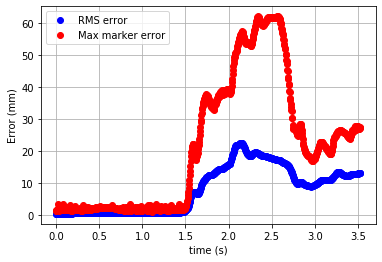

In [6]:
#tracé des données d'erreur au cours du mouvement
plt.plot(time,ERMS*1000,'ob') 
plt.plot(time,Emax*1000,'or')
plt.grid()
plt.legend(['RMS error','Max marker error'])
plt.xlabel('time (s)')
plt.ylabel('Error (mm)')
plt.show()

